In [2]:
import requests
import pickle
import pandas as pd
import json as js
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.cluster import KMeans
from matplotlib.dates import DateFormatter, date2num
import plotly.express as px
import math
import datetime as dt
import matplotlib.lines as mlines

In [3]:
players_df = pd.concat(map(pd.read_csv, ['players_df_2021_1.csv', 'players_df_2021_2.csv']))
teams_df = pd.concat(map(pd.read_csv, ['teams_df_2021_1.csv', 'teams_df_2021_2.csv']))
teams_df = teams_df.drop_duplicates()
teams_df = teams_df.sort_values('id')
games_df = pd.concat(map(pd.read_csv, ['games_df_2021_1.csv', 'games_df_2021_2.csv']))
#events_df = pd.read_csv('events_df.csv')
#players_df.to_csv('players_final.csv')
#teams_df.to_csv('teams_final.csv')
#games_df.to_csv('games_final.csv')

In [4]:
events_df = pd.concat(map(pd.read_csv, ['events_df_2021_1.csv', 'events_df_2021_2.csv']))

In [5]:
#EVENTS_DF cicomazas
#Nullas sorok feltoltese hogy utana int-re valtoztathassuk
events_df = events_df.fillna(0)
events_df = events_df.astype({'player1Id': 'int64','player2Id':'int64','player3Id':'int64','player4Id':'int64',
                              'coX': 'int64','coY':'int64'})

In [6]:
#Distinct jatek datumok uj dataframeben mert az elejen elfelejtettem belevenni a read api-ba
date_df =  games_df.loc[:,['pk','startDate']]
#Ramergeljuk az events_df-re
events_df = pd.merge(left=events_df, right=date_df, left_on='gameId', right_on='pk', how='left')
events_df = events_df.drop(columns=['pk'])
#A datum vegerol levagjuk a felesleges reszt hogy szep legyen
events_df['startDate'] = events_df['startDate'].str[:10]

In [7]:
#A periodTime konvertalasa Timedelta tipusra
events_df['periodTimeFull'] = pd.to_timedelta(events_df['periodTime'].apply(lambda x: f'00:{x}'))
#periodtime atszamitasa teljes idotartamra a 3x20 perc helyett
events_df['periodTimeFull']  = events_df['periodTimeFull'] + ((events_df['period']-1) * pd.to_timedelta('00:20:00'))
#Kerekitjuk percekre
events_df['periodTimeFull_rounded'] = events_df['periodTimeFull'].dt.round('60s')

In [1342]:
#Tukrozzuk az esemenyeket az origora, nagyon sokaig tart...
for idx, i in enumerate(events_df['coX']):
    if i<0:
        events_df['coX'].iloc[idx] = abs(events_df['coX'].iloc[idx])
        events_df['coY'].iloc[idx] = events_df['coY'].iloc[idx]*-1

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3733899911.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/3733899911.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
#Shot distance and angle
goalcenter_x = 89
goalcenter_y = 0

events_df['shot_angle'] = events_df[['coX','coY']].apply(
    lambda row: np.arctan(row['coY']/(goalcenter_x-row['coX']))*(180/np.pi),
    axis=1)

events_df['shot_distance'] = events_df[['coX','coY']].apply(
    lambda row: np.sqrt((row['coX']-goalcenter_x)**2 + (row['coY']-goalcenter_y)**2), axis=1)

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_13054/1372240050.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  lambda row: np.arctan(row['coY']/(89-row['coX']))*(180/np.pi),


In [1344]:
#events_df.dtypes
#events_df[300:]
#events_df.to_csv('events_final.csv')

In [1345]:
#Data Exploratory: Atlagos eletkor
avg_age = pd.DataFrame()
avg_age = round(players_df.groupby('teamID')['currentAge'].mean(),1).sort_values()
teamsname = teams_df[['id','name']]
agebyteams = pd.merge(left=avg_age, right=teamsname, left_on='teamID', right_on='id', how='left')
agebyteams

,currentAge,id,name
0,25.7,1,New Jersey Devils
1,26.2,29,Columbus Blue Jackets
2,26.5,9,Ottawa Senators
3,26.6,3,New York Rangers
4,26.6,26,Los Angeles Kings
5,26.7,7,Buffalo Sabres
6,26.8,17,Detroit Red Wings
7,27.2,16,Chicago Blackhawks
8,27.4,18,Nashville Predators
9,27.5,8,Montréal Canadiens


Text(0.5, 0, 'Kor')

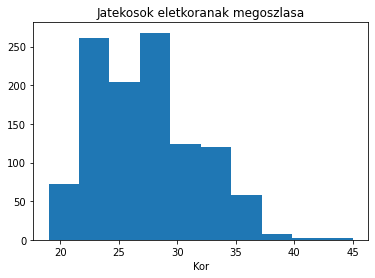

In [1346]:
#Data Exploratory: Atlagos eletkor histogram
playersage = players_df[['id','currentAge']]
playersage = playersage.drop_duplicates()
playersage = playersage.drop(columns=['id'])
plt.hist(playersage)
plt.title('Jatekosok eletkoranak megoszlasa')
plt.xlabel('Kor')

In [1519]:
#Uj dataframe meghatarozott ember meghatarozott esemenyeivel
sog_df = pd.DataFrame()
sog_df = events_df[events_df['eventType'].isin(['Goal'])]
sog_df = sog_df[sog_df['player1Id'].isin([8471214])]
sog_df = sog_df.drop_duplicates()

sog_df

,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,player3Type,player4Id,player4Type,startDate,periodTimeFull,periodTimeFull_rounded,shot_angle,shot_distance,shot_angle_rad,shot_angle_vis
1223,2021020004,213,Goal,"Alex Ovechkin (1) Wrist Shot, assists: Anthony...",3,02:37,REGULAR,3,15,4,...,Assist,8480382,Goalie,2021-10-13,0 days 00:42:37,0 days 00:43:00,49.763642,17.029386,0.868539,0.702257
1267,2021020004,257,Goal,"Alex Ovechkin (2) Backhand, assists: Evgeny Ku...",3,12:01,REGULAR,3,15,5,...,Assist,8480382,Goalie,2021-10-13,0 days 00:52:01,0 days 00:52:00,30.963757,5.830952,0.540420,1.030377
8630,2021020027,189,Goal,"Alex Ovechkin (3) Snap Shot, assists: Trevor v...",2,18:51,REGULAR,14,15,1,...,Assist,8476883,Goalie,2021-10-16,0 days 00:38:51,0 days 00:39:00,-3.691386,31.064449,-0.064427,1.635223
14302,2021020045,288,Goal,"Alex Ovechkin (4) Wrist Shot, assists: Tom Wil...",3,17:39,REGULAR,21,15,6,...,Assist,0,0,2021-10-19,0 days 00:57:39,0 days 00:58:00,30.256437,41.677332,0.528074,1.042722
22731,2021020072,182,Goal,"Alex Ovechkin (5) Wrist Shot, assists: none",2,18:03,REGULAR,20,15,3,...,0,0,0,2021-10-23,0 days 00:38:03,0 days 00:38:00,35.753887,30.805844,0.624023,0.946773
26513,2021020084,230,Goal,"Alex Ovechkin (6) Wrist Shot, assists: none",2,16:27,REGULAR,15,9,4,...,0,0,0,2021-10-25,0 days 00:36:27,0 days 00:36:00,-16.699244,10.440307,-0.291457,1.862253
26584,2021020084,301,Goal,"Alex Ovechkin (7) Wrist Shot, assists: Tom Wil...",3,10:46,REGULAR,15,9,5,...,Goalie,0,0,2021-10-25,0 days 00:50:46,0 days 00:51:00,16.389540,35.440090,0.286051,1.284745
30770,2021020098,78,Goal,"Alex Ovechkin (8) Snap Shot, assists: Lars Ell...",1,19:05,REGULAR,17,15,1,...,Assist,8471306,Goalie,2021-10-27,0 days 00:19:05,0 days 00:19:00,66.801409,7.615773,1.165905,0.404892
35618,2021020113,262,Goal,"Alex Ovechkin (9) Wrist Shot, assists: Evgeny ...",3,19:39,REGULAR,53,15,2,...,Assist,0,0,2021-10-29,0 days 00:59:39,0 days 01:00:00,21.194056,52.554733,0.369906,1.200890
47827,2021020152,217,Goal,"Alex Ovechkin (10) Wrist Shot, assists: Lars E...",2,18:11,REGULAR,15,13,4,...,Goalie,0,0,2021-11-04,0 days 00:38:11,0 days 00:38:00,25.769328,32.202484,0.449760,1.121037


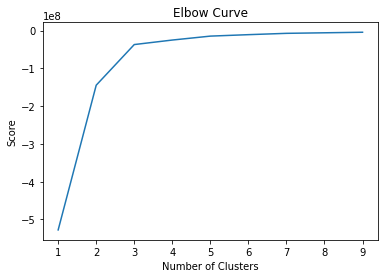

In [23]:
#Meghatarozzuk, hany klaszter erdemes letrehozni a koordinatakra (a konyokpont erteke kell nekunk, ahonnan mar
#nem novekszik tovabb lavanyosan a fgv.)
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = events_df[['coX']]
X_axis = events_df[['coY']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [1531]:
#Letrehozunk egy uj dataframet a koordinatas vizualizaciohoz az x es y koordinatakkal
X = sog_df.loc[:,['coX','coY']]

X_round = sog_df.loc[:,['coX','coY']]

#Uj dataframe, szamok kerekitve a masodik fajta vizualizaciohoz, hogy a szinek jol nezzenek ki:
for idx, i in X_round.iterrows():
    X_round.loc[idx,'coX'] = (round(X_round.loc[idx,'coX']/5.0)*5.0)
    X_round.loc[idx,'coY'] = (round(X_round.loc[idx,'coY']/5.0)*5.0)
#X
X_round

,coX,coY
1223,80,15
1267,85,5
8630,60,0
14302,55,20
22731,65,20
26513,80,-5
26584,55,10
30770,85,5
35618,40,20
47827,60,15


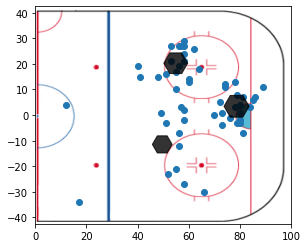

In [1529]:
#A meghatarozott klaszterszamot megadva klaszterekbe soroljuk a koordinatakat
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[0:2]]) # Labels of each point
#X

#Kiszamoljuk a pottyok meretet, a klaszterek elemszamat vesszuk es megszorozzuk valamennyiel, hogy nagyobb legyen.
size = X.groupby(['cluster_label']).count()
size = size['coX']*30

#Ket valtozot inicializalunk aminek megadjuk az X es Y oszlopunkat, hogy kesobb be tudjuk taplalni a plot-ba
coX = X['coX']
coY = X['coY']
img = plt.imread("Half_ice_hockey_rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 100, -42.5, 42.5])
ax.scatter(coX, coY)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=size, marker='H', alpha=0.8)
plt.xlim(0,100)
plt.ylim(-42.5,42.5)
plt.show()

In [1536]:
#Goal - Assist pairs
Y = sog_df.loc[:,['player1Id','player2Id']]
Y = Y.groupby(['player1Id', 'player2Id']).size().sort_values(ascending=False).reset_index(name='count') 
Y

,player1Id,player2Id,count
0,8471214,8475744,15
1,8471214,8474590,8
2,8471214,8475200,4
3,8471214,8476880,4
4,8471214,8477839,2
5,8471214,8473563,2
6,8471214,8474189,2
7,8471214,8477903,2
8,8471214,8477845,2
9,8471214,0,1


In [14]:
players_distinct = players_df.loc[:,['id','fullName','teamID']]
players_distinct.drop_duplicates()
#players_distinct

pairs = events_df.loc[:,['player1Id','player2Id','player3Id','eventType']]
pairs = pairs[pairs['eventType'].isin(['Goal'])]
pairs = pairs.groupby(['player1Id', 'player2Id','player3Id']).size().sort_values(ascending=False).reset_index(name='count')
#pairs

pairs2 = pd.merge(left=pairs, right=players_distinct, left_on='player2Id', right_on='id',how='left')
pairs2 = pairs2.rename(columns={"fullName": "player2Name"})
pairs2 = pairs2.drop(columns='id')
#pairs2

pairs3 = pd.merge(left=pairs2, right=players_distinct, left_on='player3Id', right_on='id',how='left')
pairs3 = pairs3.rename(columns={"fullName": "player3Name", 'teamID_x':'teamID'})
pairs3 = pairs3.fillna(0)
pairs3 = pairs3.astype({'teamID': 'int64'})
pairs3 = pairs3.drop(columns=['id','teamID_y'])
pairs3.to_csv('goalassist.csv')
pairs3

,player1Id,player2Id,player3Id,count,player2Name,teamID,player3Name
0,8479337,8474141,8477495,10,Patrick Kane,16,Seth Jones
1,8479337,8474141,8477495,10,Patrick Kane,16,Seth Jones
2,8479337,8474141,8477495,10,Patrick Kane,16,Seth Jones
3,8479337,8474141,8477495,10,Patrick Kane,16,Seth Jones
4,8479337,8474141,8477495,10,Patrick Kane,16,Seth Jones
...,...,...,...,...,...,...,...
11125206,8483570,8481186,8476312,1,Logan O'Connor,21,Josh Manson
11125207,8483570,8481186,8476312,1,Logan O'Connor,21,Josh Manson
11125208,8483570,8481186,8476312,1,Logan O'Connor,21,Josh Manson
11125209,8483570,8481186,8476312,1,Logan O'Connor,21,Josh Manson


In [15]:
players_distinct.to_csv('players_distinct.csv')

In [1534]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
df_counts = X_round.groupby(['coX', 'coY']).size().reset_index(name='counts')

fig = px.scatter(df_counts, x='coX', y='coY',
                 color='counts',
                 size='counts',
                 width=685, height=580)

fig.update_layout(yaxis_range=[-42.5,42.5])
fig.update_layout(xaxis_range=[0,100])

# Remove side scale and hide zero and gridlines
fig.update_layout(
    coloraxis_showscale=True,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),)
# Disable axis ticks and labels
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')

fig.add_layout_image(
        dict(
            source='Half_ice_hockey_rink.png',
            xref="x",
            yref="y",
            x=0,
            y=42,
            sizex=100,
            sizey=85,
            sizing="stretch",
            opacity=0.5,
            layer="below")
)

fig.update_layout(template="plotly_white")
#df_counts
fig.show()

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_13054/132157914.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_13054/132157914.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_13054/132157914.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



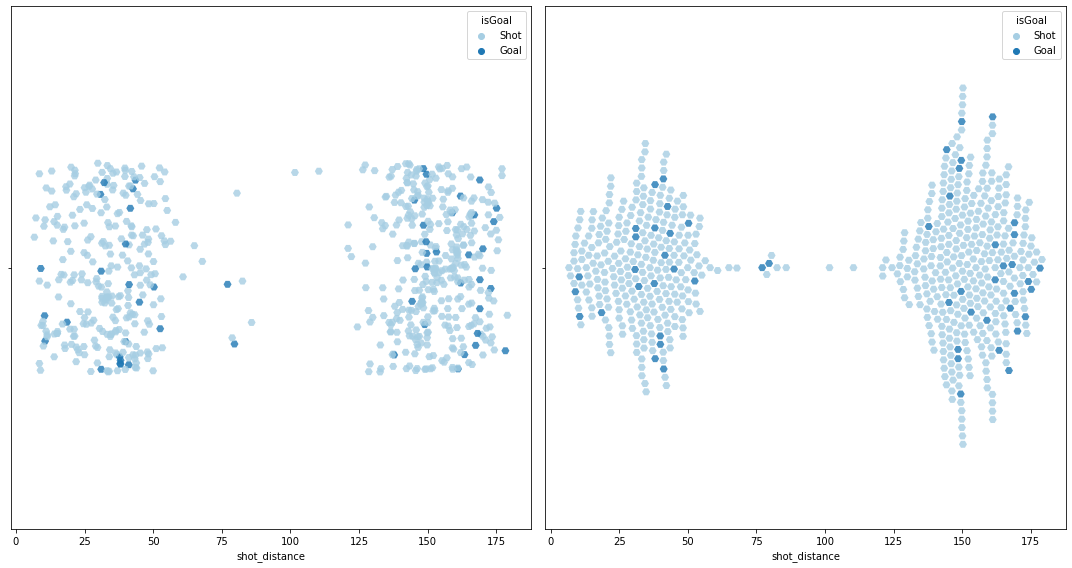

In [37]:
#Koordinatakban van megadva a tavolsag, atszamolni meterre?
dist1 = events_df[['shot_distance','player1Id','eventType']]
dist1 = dist1[dist1['eventType'].isin(['Shot','Missed Shot','Goal'])]
dist1 = dist1[dist1['player1Id'].isin([8471214])]

dist2 = events_df[['shot_distance','player2Id','eventType']]
dist2 = dist2[dist2['eventType'].isin(['Blocked Shot'])]
dist2 = dist2.rename(columns={"player2Id": "player1Id"})
dist2 = dist2[dist2['player1Id'].isin([8471214])]

dist = dist1.append(dist2, ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))

dist['isGoal'] = ''

for idx, i in enumerate(dist['eventType']):
    if i == 'Goal':
        dist['isGoal'].iloc[idx] = "Goal"
    else:
        dist['isGoal'].iloc[idx] = "Shot"
        

sb.stripplot(data=dist, x=dist['shot_distance'], y=[""]*len(dist), ax=ax1, hue=dist['isGoal'],palette="Paired", 
             size=8, marker="H", edgecolor="gray", alpha=.8, jitter = .2)

sb.swarmplot(data=dist, x=dist['shot_distance'], ax=ax2,  y=[""]*len(dist), hue=dist['isGoal'],palette=('Paired'), 
             size=8, marker="H",edgecolor="gray", alpha=.8)

plt.tight_layout()

In [1180]:
#events_df.player1Type.unique() #'Winner', 'Scorer', 'Shooter', 'PenaltyOn', 'PlayerID','Blocker', 'Hitter'
#events_df.player2Type.unique() #'Loser', 'Assist', 'DrewBy', 'Goalie', 'Shooter', 'Hittee' 
    #(Blocked Shot-nal elso a Blocker masodik a Shooter)
#events_df.player3Type.unique() #'Assist', 'Goalie', 'ServedBy'
#events_df.player4Type.unique() #'Golie'
#events_df.eventType.unique()

In [24]:
#Shots on Goal % szamitas.
#Elso temp DataFrame: osszes kapuraloves a player 1-tol
tmp_sog = events_df[['gameId','player1Id','startDate','eventType']]
tmp_sog = tmp_sog[tmp_sog['eventType'].isin(['Shot','Missed Shot','Goal'])]
tmp_sog_calc = tmp_sog.groupby(['gameId','startDate','player1Id']).count()
tmp_sog_calc = tmp_sog_calc.rename(columns={"eventType": "allShots"})
tmp_sog_calc.reset_index(inplace=True)
#tmp_sog_calc

#Masodik temp dataframe: osszes kapuraloves a player 2-tol (Blocked Shot-nal player 2-n van logolva a Shooter)
tmp_sog_b = events_df[['gameId','player2Id','startDate','eventType']]
tmp_sog_b = tmp_sog_b[tmp_sog_b['eventType'].isin(['Blocked Shot'])]
tmp_sog_calc_b = tmp_sog_b.groupby(['gameId','startDate','player2Id']).count()
tmp_sog_calc_b = tmp_sog_calc_b.rename(columns={"eventType": "allShots"})
tmp_sog_calc_b.reset_index(inplace=True)
#tmp_sog_calc_b

#Harmadik temp DataFrame: Az osszes kapuraloves
tmp_allsog = pd.merge(left=tmp_sog_calc, right=tmp_sog_calc_b, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player2Id'], 
                          how='left')
tmp_allsog = tmp_allsog.fillna(0)
tmp_allsog = tmp_allsog.astype({'allShots_y': 'int64'})
tmp_allsog['allShots'] = tmp_allsog['allShots_x']+tmp_allsog['allShots_y']
tmp_allsog = tmp_allsog.drop(columns=['allShots_x','player2Id','allShots_y'])
#tmp_allsog

#Negyedik temp DataFrame: Az osszes Goal
tmp_goal = events_df[['gameId','player1Id','startDate','eventType']]
tmp_goal = tmp_goal[tmp_goal['eventType'].isin(['Goal'])]
tmp_goal_calc = tmp_goal.groupby(['gameId','startDate','player1Id']).count()
tmp_goal_calc = tmp_goal_calc.rename(columns={"eventType": "allGoals"})
tmp_goal_calc.reset_index()

#Vegso DataFrame: Osszes kapuraloves es goal merge, szazalek szamitas
sog_percentage = pd.merge(left=tmp_allsog, right=tmp_goal_calc, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player1Id'], 
                          how='left')

sog_percentage['sog%'] = round(((sog_percentage['allGoals']/sog_percentage['allShots'])*100),1)
sog_percentage["Date"] = pd.to_datetime(sog_percentage["startDate"])
sog_percentage.reset_index(inplace=True)
#Megjelenitsem a sok 0-t is?! Akkor fel kell tolteni a Nan-okat 0-val
#sog_percentage = sog_percentage.fillna(0)
sog_percentage

,index,gameId,startDate,player1Id,allShots,allGoals,sog%,Date
0,0,2021020001,2021-10-12,8470604,2,NaN,NaN,2021-10-12
1,1,2021020001,2021-10-12,8470619,2,1.0,50.0,2021-10-12
2,2,2021020001,2021-10-12,8471724,4,NaN,NaN,2021-10-12
3,3,2021020001,2021-10-12,8473986,3,1.0,33.3,2021-10-12
4,4,2021020001,2021-10-12,8474151,4,NaN,NaN,2021-10-12
...,...,...,...,...,...,...,...,...
40294,40294,2021021312,2022-04-30,8479987,3,NaN,NaN,2022-04-30
40295,40295,2021021312,2022-04-30,8480901,4,NaN,NaN,2022-04-30
40296,40296,2021021312,2022-04-30,8482133,3,NaN,NaN,2022-04-30
40297,40297,2021021312,2022-04-30,8482222,3,NaN,NaN,2022-04-30


<AxesSubplot:xlabel='Date', ylabel='sog%'>

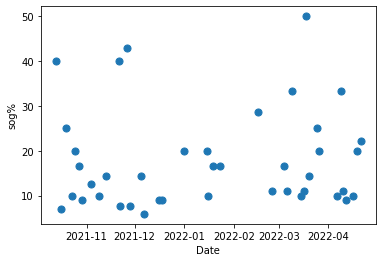

In [25]:
#Egy jatekosra nezve:
sog_perc_oneplayer = sog_percentage[['Date','player1Id','allShots','allGoals','sog%']]
sog_perc_oneplayer = sog_perc_oneplayer[sog_perc_oneplayer['player1Id'].isin([8471214])]
sog_perc_oneplayer.plot(x='Date',y='sog%', kind='scatter',s=50)

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_13054/2795957779.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<AxesSubplot:xlabel='periodTimeFull_rounded'>

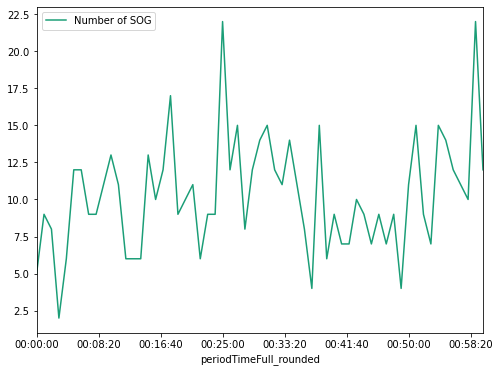

In [17]:
#Timeline: X axis-on a 60 perc, esemenyeket percre kerekitem. A szezon osszes kapuralovese az adott percben adott embertol
#A kapuraloves lehet: 'Shot','Missed Shot','Goal' es 'Blocked Shot'. Blokkoltnal a Player2-n van logolva a Shooter
#REGULAR period type
tmp_sog_time = events_df[['player1Id','eventType','periodTimeFull_rounded']]
tmp_sog_time = tmp_sog_time[tmp_sog_time['eventType'].isin(['Shot','Missed Shot','Goal'])]

tmp_sog_b_time = events_df[['player2Id','eventType','periodTimeFull_rounded']]
tmp_sog_b_time = tmp_sog_b_time[tmp_sog_b_time['eventType'].isin(['Blocked Shot'])]
tmp_sog_b_time = tmp_sog_b_time.rename(columns={"player2Id": "player1Id"})

timechart = tmp_sog_time.append(tmp_sog_b_time, ignore_index=True)

#REGULAR period type (OverTime es Shootout kiszurese):
timechart = timechart.loc[timechart['periodTimeFull_rounded'] <= pd.to_timedelta('01:00:00')]

timechart = timechart[timechart['player1Id'].isin([8471214])]

timechart = timechart.groupby(['periodTimeFull_rounded']).count()
timechart = timechart.drop(columns=['eventType'])
timechart = timechart.rename(columns={"player1Id": "Number of SOG"})
timechart.reset_index(inplace=True)
timechart.plot(x='periodTimeFull_rounded', figsize=(8,6), cmap='Dark2')
#px.line(timechart, x="periodTimeFull_rounded", y="Number of SOG", title='# of SOG')
#timechart

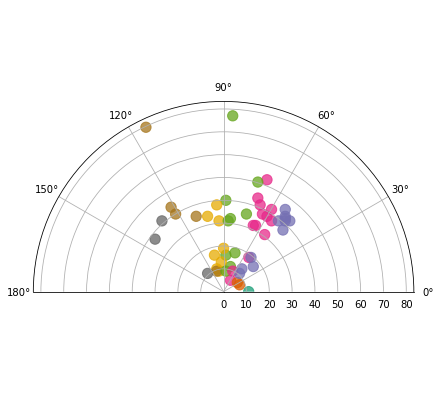

In [1361]:
#Szogek vizualizalasa
#Atszamoljuk radianra, aztan elforgatjuk hogy 0-180 kozott tudjam abrazolni
events_df['shot_angle_rad'] = events_df['shot_angle']*(math.pi/180)
events_df['shot_angle_vis'] = events_df['shot_angle_rad']*-1+(math.pi/2)

#Parameterek, pl Ovechkin goljai:
angledf = pd.DataFrame()
angledf = events_df[events_df['eventType'].isin(['Goal'])]
angledf = angledf[angledf['player1Id'].isin([8471214])]

theta = angledf['shot_angle_vis']
r = angledf['shot_distance']
area = angledf['shot_angle_rad'].count()
colors = theta
size = angledf['shot_angle_vis'].count()*2

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta, r, s=size, cmap='Dark2', c = colors, alpha=0.75)
plt.gcf().set_size_inches(8, 7)

ax.set_thetamin(0)
ax.set_thetamax(180)

,Player,Goals_21,ixG_21
6,Connor McDavid,22,22.75


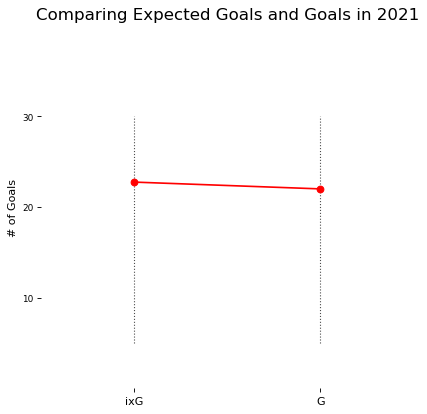

In [42]:
#UPDATELNI KELL 2021-RE!!
#Individual Expected Goals: ixG, letoltott csv-ben vannak statisztikai szamaim, ezt csak beolvasom, nem API-zok
players_stat_18 = pd.read_csv('playerstats_2018.csv')
players_stat_19 = pd.read_csv('playerstats_2019.csv')
players_stat_21 = pd.read_csv('playerstats_21.csv')

name = 'Connor McDavid'

#Dataframek amiben csak az ixG kerul 1 emberre
oneplayerstat_18 = players_stat_18.loc[:,['Player', 'Goals', 'ixG']]
oneplayerstat_18 = oneplayerstat_18[oneplayerstat_18['Player'] == (name)]
oneplayerstat_18 = oneplayerstat_18.rename(columns={"ixG": "ixG_18", 'Goals':'Goals_18'})

oneplayerstat_19 = players_stat_19.loc[:,['Player', 'Goals', 'ixG']]
oneplayerstat_19 = oneplayerstat_19[oneplayerstat_19['Player'] == (name)]
oneplayerstat_19 = oneplayerstat_19.rename(columns={"ixG": "ixG_19", 'Goals':'Goals_19'})

oneplayerstat_21 = players_stat_21.loc[:,['Player', 'Goals', 'ixG']]
oneplayerstat_21 = oneplayerstat_21[oneplayerstat_21['Player'] == (name)]
oneplayerstat_21 = oneplayerstat_21.rename(columns={"ixG": "ixG_21", 'Goals':'Goals_21'})

ixg_1819 = pd.merge(left=oneplayerstat_18, right=oneplayerstat_19, left_on = 'Player', right_on='Player', how='left')
ixg = oneplayerstat_21

fig, ax = plt.subplots(1,1,figsize=(6,6), dpi= 80)

#Vertical lines
ax.vlines(x=1, ymin=5, ymax=30, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=5, ymax=30, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
#ax.scatter(y=ixg['Goals_18'], x=np.repeat(1, ixg.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=ixg['Goals_21'], x=np.repeat(3, ixg.shape[0]), s=10, color='black', alpha=0.7)
ax.scatter(y=ixg['ixG_21'], x=np.repeat(1, ixg.shape[0]), s=10, color='black', alpha=0.7)
#ax.scatter(y=ixg['Goals_18'], x=np.repeat(3, ixg.shape[0]), s=10, color='black', alpha=0.7)

def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p1[1]-p2[1] > 0 else 'green', marker='o', markersize=6)
    ax.add_line(l)
    return l

# Line Segmentsand Annotation
#for p1, p2 in zip(ixg['Goals_18'], ixg['Goals_19']):
 #   newline([1,p1], [3,p2])
    
for p1, p2 in zip(ixg['ixG_21'], ixg['Goals_21']):
    newline([1,p1], [3,p2])
    
# Decoration
ax.set_title("Comparing Expected Goals and Goals in 2021", fontdict={'size':15})
ax.set(xlim=(0,4), ylim=(0,40), ylabel='# of Goals')
ax.set_xticks([1,3])
ax.set_xticklabels(["ixG", "G"])
plt.yticks((10, 20, 30), fontsize=8)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)

#ixg.to_csv('ixg_21.csv')
ixg